# DogFaceNet version 7: final version!
IT WORKS!!!

### Imports and constants

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import pickle
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow.keras.backend as K

In [37]:
PATH = '../data/dogfacenet/aligned/after_2/'
PATH_SAVE = '../output/history/'
PATH_MODEL = '../output/model/'
SIZE = (104,104,3)
VALID_SPLIT = 0.1
TEST_SPLIT = 0.05

### Data pre-processing
- Load image and labels
- Training set, validation set (close-set) and testing (open-set)

In [3]:
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1
print(len(labels))
h,w,c = SIZE
images = np.empty((len(filenames),h,w,c))
for i,f in enumerate(filenames):
    images[i] = sk.io.imread(f)

3148


In [4]:
# Normalization
images /= 255.0


In [5]:
nbof_classes = len(np.unique(labels))
print(nbof_classes)

485


Open-set: test set

In [6]:
nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels,nbof_test)
keep_train = np.logical_not(keep_test)

images_test = images[keep_test]
labels_test = labels[keep_test]

images_train = images[keep_train]
labels_train = labels[keep_train]

Triplet definition

In [7]:
def define_triplets(images,labels,nbof_triplet = 10000 * 3):
    triplet_train = np.empty((nbof_triplet,h,w,c))
    y_triplet = np.empty(nbof_triplet)
    classes = np.unique(labels)
    for i in tqdm_notebook(range(0,nbof_triplet,3)):
        # Pick a class and chose two pictures from this class
        classAP = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classAP)
        keep_classAP = images[keep]
        keep_classAP_idx = labels[keep]
        idx_image1 = np.random.randint(len(keep_classAP))
        idx_image2 = np.random.randint(len(keep_classAP))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(keep_classAP))

        triplet_train[i] = keep_classAP[idx_image1]
        triplet_train[i+1] = keep_classAP[idx_image2]
        y_triplet[i] = keep_classAP_idx[idx_image1]
        y_triplet[i+1] = keep_classAP_idx[idx_image2]
        # Pick a class for the negative picture
        classN = classes[np.random.randint(len(classes))]
        while classN==classAP:
            classN = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classN)
        keep_classN = images[keep]
        keep_classN_idx = labels[keep]
        idx_image3 = np.random.randint(len(keep_classN))
        triplet_train[i+2] = keep_classN[idx_image3]
        y_triplet[i+2] = keep_classN_idx[idx_image3]
        
    return triplet_train, y_triplet

In [8]:
triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)

[258. 258. 129. 469. 469.  88. 413. 413.  71. 301. 301. 181. 341. 341.
 288.  58.  58.  43. 372. 372. 128. 313. 313. 187.]


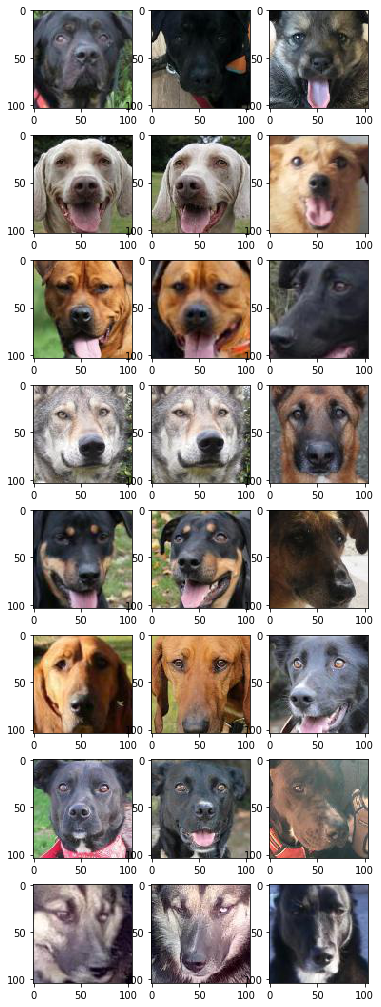

In [11]:
# Test
# Check the triplet
print(y_triplet_train[:24])
plt.figure(figsize=(6,18))
for i in range(0,24):
    plt.subplot(8,3,i+1)
    plt.imshow(triplet_train[i])

In [10]:
# Data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    #zca_whitening=True
)
train_datagen.fit(images_train[:10])

### Loss definition

In [26]:
alpha = 0.3
def cos_triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(a*p,-1) * 0.5 + 0.5
    an = K.sum(a*n,-1) * 0.5 + 0.5

    return tf.nn.relu(ap - an + alpha)

In [21]:
alpha = 0.3
def triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

In [20]:
y = tf.constant([1.,0,1,0,0])
keep = K.cast(K.equal(y,1),tf.float32)
e = y * keep
s = K.sum(e)
out = s / K.sum(keep)
with tf.Session() as sess:
    print(sess.run([keep,e,s,out]))

[array([1., 0., 1., 0., 0.], dtype=float32), array([1., 0., 1., 0., 0.], dtype=float32), 2.0, 1.0]


In [10]:
# The following version was found in a blog post
from triplet_loss import batch_all_triplet_loss
def triplet(y_true,y_pred):
    y_true = y_true[:,0]
    y_true = tf.reshape(y_true,[-1])
    loss,_ = batch_all_triplet_loss(y_true,y_pred,0.3)
    return loss

### Metric definition

In [27]:
def cos_triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(a*p,-1) * 0.5 + 0.5
    an = K.sum(a*n,-1) * 0.5 + 0.5
    
    return K.less(ap,an)

In [22]:
def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)
    
    return K.less(ap,an)

### Model definition

In [24]:
# dogfacenet_v6
emb_size = 18

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(104, 104, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1)))

model.compile(loss=triplet,
              optimizer='rmsprop',
              metrics=[triplet_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 102, 102, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 24, 24, 128)       0         
__________

In [27]:
triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)

In [29]:
history=model.fit(
    triplet_train,
    y_triplet_train,
    batch_size = 21*3,
    epochs = 1,
    validation_data=(triplet_test,y_triplet_test),
    shuffle=False
)

Train on 30000 samples, validate on 3000 samples
Epoch 1/1
30000/30000 [==============================] - 73s 2ms/step - loss: 0.8507 - triplet_acc: 0.9470 - val_loss: 0.7797 - val_triplet_acc: 0.9470


In [28]:
histories = []
n = 2
for i in range(n):
    history=model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = n-i,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    histories += [history]
    triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
    triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)
    

Train on 30000 samples, validate on 3000 samples
Epoch 1/2
30000/30000 [==============================] - 74s 2ms/step - loss: 1.0451 - triplet_acc: 0.9351 - val_loss: 0.9444 - val_triplet_acc: 0.9500
Epoch 2/2
30000/30000 [==============================] - 74s 2ms/step - loss: 0.9083 - triplet_acc: 0.9414 - val_loss: 1.0567 - val_triplet_acc: 0.9390



Train on 30000 samples, validate on 3000 samples
Epoch 1/1
30000/30000 [==============================] - 73s 2ms/step - loss: 0.8849 - triplet_acc: 0.9443 - val_loss: 0.8968 - val_triplet_acc: 0.9500


In [38]:
model.save(PATH_MODEL+'2019.02.08.dogfacenet_v7.h5')

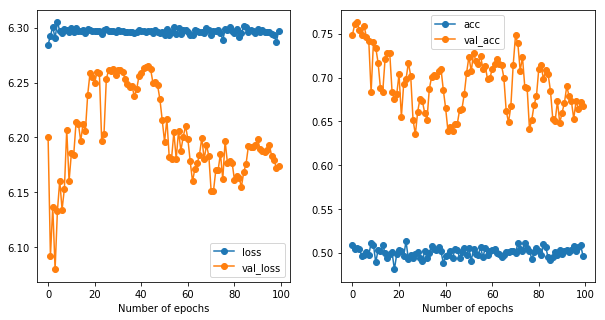

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['triplet_acc']
val_acc = history.history['val_triplet_acc']
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.08.dogfacenet_v6.triplet.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.08.dogfacenet_v6.triplet.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

### Evaluate it

#### Evaluate on verification task

In [30]:
# Create pairs
h,w,c = SIZE
pairs = np.empty((len(images_test)*2,h,w,c))
issame = np.empty(len(images_test))
class_test = np.unique(labels_test)
for i in range(len(images_test)):
    alea = np.random.rand()
    # Pair of different dogs
    if alea < 0.5:
        # Chose the classes:
        class1 = np.random.randint(len(class_test))
        class2 = np.random.randint(len(class_test))
        while class1==class2:
            class2 = np.random.randint(len(class_test))
            
        # Extract images of this class:
        images_class1 = images_test[np.equal(labels_test,class1)]
        images_class2 = images_test[np.equal(labels_test,class2)]
        
        # Chose an image amoung these selected images
        pairs[i*2] = images_class1[np.random.randint(len(images_class1))]
        pairs[i*2+1] = images_class2[np.random.randint(len(images_class2))]
        issame[i] = 0
    # Pair of same dogs
    else:
        # Chose a class
        clas = np.random.randint(len(class_test))
        images_class = images_test[np.equal(labels_test,clas)]
        
        # Select two images from this class
        idx_image1 = np.random.randint(len(images_class))
        idx_image2 = np.random.randint(len(images_class))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(images_class))
        
        pairs[i*2] = images_class[idx_image1]
        pairs[i*2+1] = images_class[idx_image2]
        issame[i] = 1

[1. 0. 0. 1. 1.]


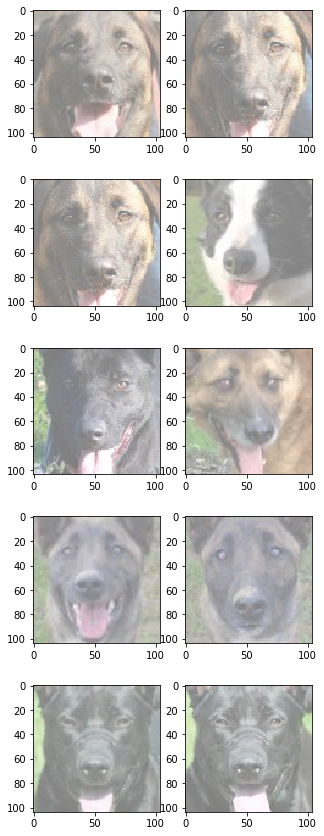

In [31]:
# Test: Check the pairs
s = 10
n = 5
print(issame[s:(n+s)])
fig = plt.figure(figsize=(5,3*n))
for i in range(s,s+n):
    plt.subplot(n,2,2*(i-s)+1)
    plt.imshow(pairs[2*i]*0.5+0.5)
    plt.subplot(n,2,2*(i-s)+2)
    plt.imshow(pairs[2*i+1]*0.5+0.5)

In [35]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)

# Compute the angle between pairs

best = 0
best_t = 0
thresholds = np.arange(0.0001,4,0.001)
for i in range(len(thresholds)):
    less = np.less(dist, thresholds[i])
    acc = np.logical_not(np.logical_xor(less, issame))
    acc = acc.astype(float)
    out = np.sum(acc)
    out = out/len(acc)
    if out > best:
        best_t = thresholds[i]
        best = out

print("Best threshold: " + str(best_t))
print("Best accuracy: " + str(best))

Best threshold: 0.6391
Best accuracy: 0.8838709677419355


### Face clustering

In [42]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(images_test)

In [47]:
from sklearn.cluster import KMeans

In [56]:
kmeans = KMeans(n_clusters=len(np.unique(labels_test)), random_state=0).fit(predict)

In [71]:
images_cluster = [images_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]
labels_cluster = [labels_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]

[ 9.  9.  9.  9. 12. 12. 12. 12. 12. 12. 12. 13.]


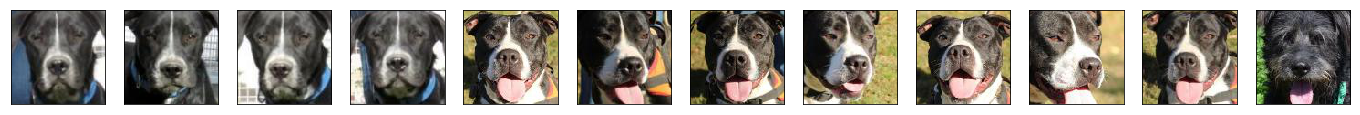

[17. 18. 18. 18.]


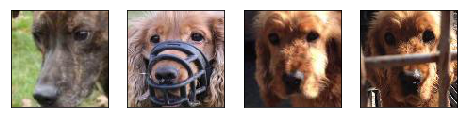

[ 5.  5.  5.  5.  5.  5. 17.]


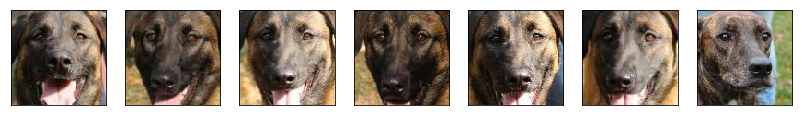

[16. 16. 16. 16. 16. 18.]


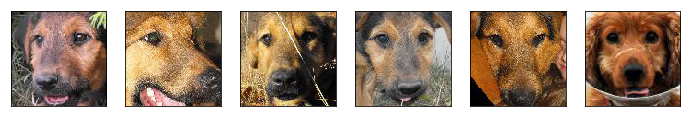

[14. 14. 14.]


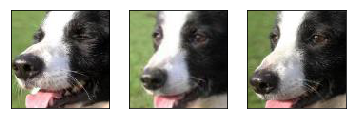

[ 1.  1.  1.  1. 10.]


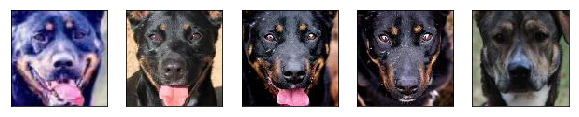

[ 0.  0.  0.  0.  0.  0. 22. 22. 22. 22. 22. 23. 23.]


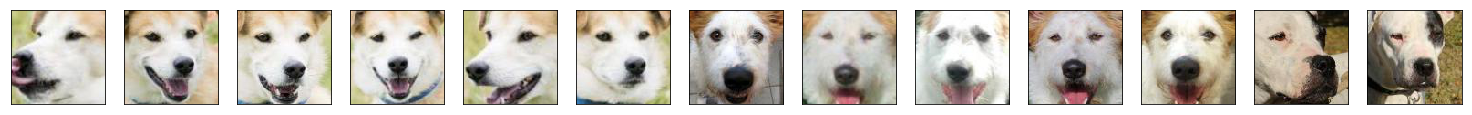

[ 2. 13. 22. 23.]


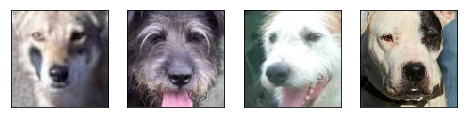

[13. 14. 14. 14. 21. 21. 21. 21. 21.]


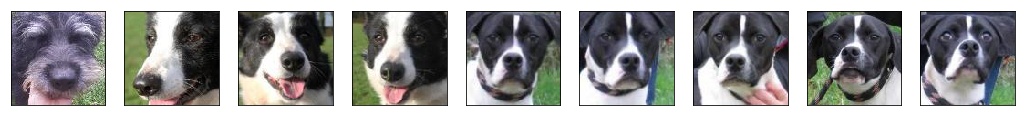

[ 4.  6.  6.  6.  6.  6. 16.]


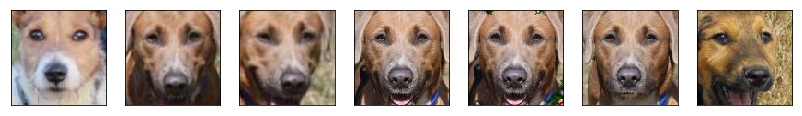

[ 8. 17. 17. 17. 20. 20. 20. 20. 20. 20.]


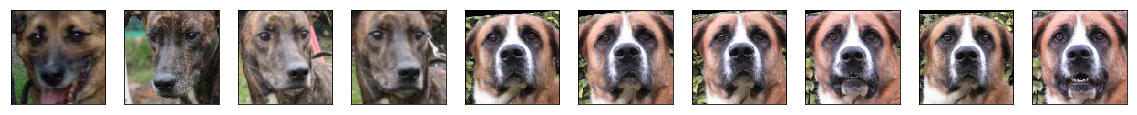

[ 9. 15. 19. 19. 19. 19. 19.]


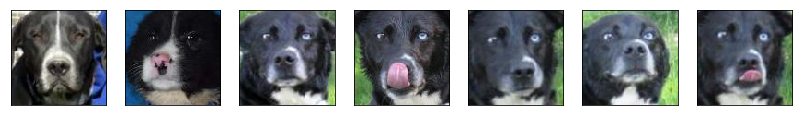

[ 2.  2. 16. 16. 16. 16. 16. 16.]


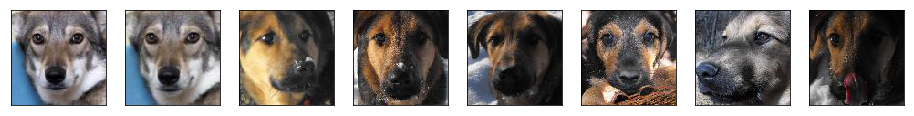

[ 3.  3.  7.  7.  7. 11. 11. 11. 11. 13.]


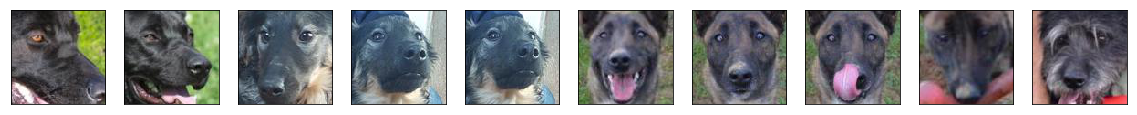

[16. 16.]


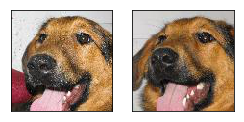

[ 4.  4. 16. 18. 18. 18. 18. 18. 18. 18. 18.]


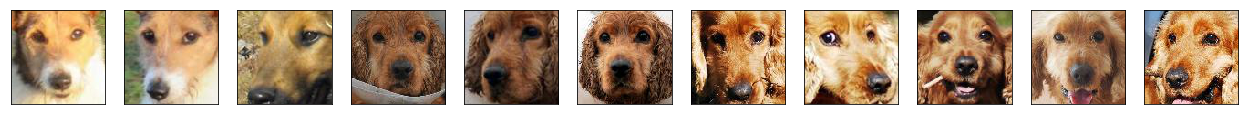

[ 8. 16. 16. 18. 18. 18.]


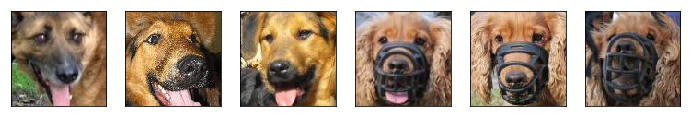

[23. 23. 23. 23.]


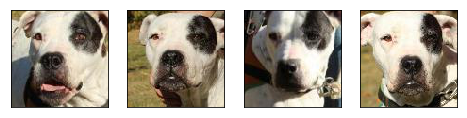

[12. 15. 15. 15. 15.]


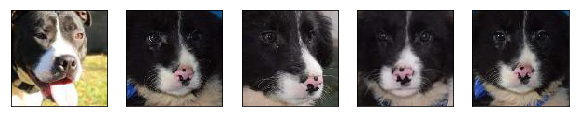

[ 7.  7. 10. 13. 17.]


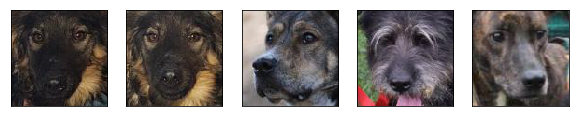

[10. 10. 10.]


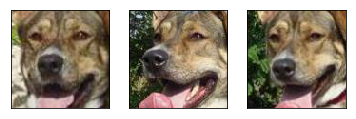

[16. 16. 16. 18.]


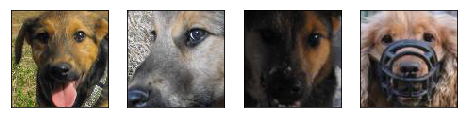

[3. 3. 3. 3. 3. 3.]


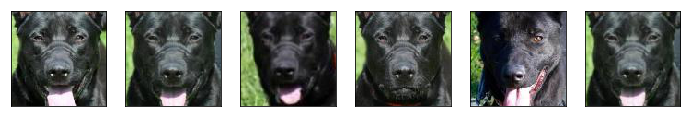

[ 8. 16. 16. 16.]


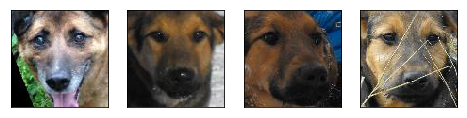

In [77]:
for i in range(24):
    length = len(images_cluster[i])
    print(labels_cluster[i])
    plt.figure(figsize=(length*2,2))
    for j in range(length):
        plt.subplot(1,length,j+1)
        plt.imshow(images_cluster[i][j])
        plt.xticks([])
        plt.yticks([])
    plt.show()

### Recognition

In [95]:
s = 60.
m = 0.3
def cosine(y_true,y_pred):
    
    exp_s = K.exp(s * y_pred)
    exp_s_m = K.exp(s * (y_pred - m))
    
    masked_exp_s_m = exp_s_m * y_true
    
    inv_mask = 1. - y_true
    masked_exp_s = exp_s * inv_mask
    
    den = K.sum(masked_exp_s + masked_exp_s_m, axis=-1, keepdims=True)
    out = masked_exp_s_m / den
    out = K.sum(out,axis=-1)
    ret = - K.log(out)
    ret = K.sum(ret)
    return ret

In [97]:
class Cosine(tf.keras.layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Cosine, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[-1],self.output_dim))

        self.kernel = self.add_weight(name='kernel', 
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        super(Cosine, self).build(input_shape)

    def call(self, x):
        x = tf.math.l2_normalize(x, axis=-1)
        w = tf.math.l2_normalize(self.kernel, axis=0)
        
        return K.dot(x, w)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [84]:
labels_test_exp = tf.keras.utils.to_categorical(labels_test)

In [98]:
#out = tf.keras.layers.Dense(128, activation='relu')(model.output)
out = Cosine(24)(model.output)
#out = tf.keras.layers.Dense(24, activation='softmax')(out)
recog = tf.keras.Model(model.input,out)
for layer in model.layers: layer.trainable = False
recog.compile(tf.keras.optimizers.Adam(),loss=cosine,metrics=['accuracy'])

In [101]:
recog.fit(images_test,labels_test_exp,batch_size=64,epochs=5)

Epoch 1/5
155/155 [==============================] - 0s 1ms/step - loss: 952.4064 - acc: 0.5419
Epoch 2/5
155/155 [==============================] - 0s 961us/step - loss: 961.6472 - acc: 0.5677
Epoch 3/5
155/155 [==============================] - 0s 1ms/step - loss: 936.5554 - acc: 0.5871
Epoch 4/5
155/155 [==============================] - 0s 1ms/step - loss: 974.9768 - acc: 0.5355
Epoch 5/5
155/155 [==============================] - 0s 1ms/step - loss: 897.3428 - acc: 0.5935


### Observation on the heatmap

In [40]:
model.layers

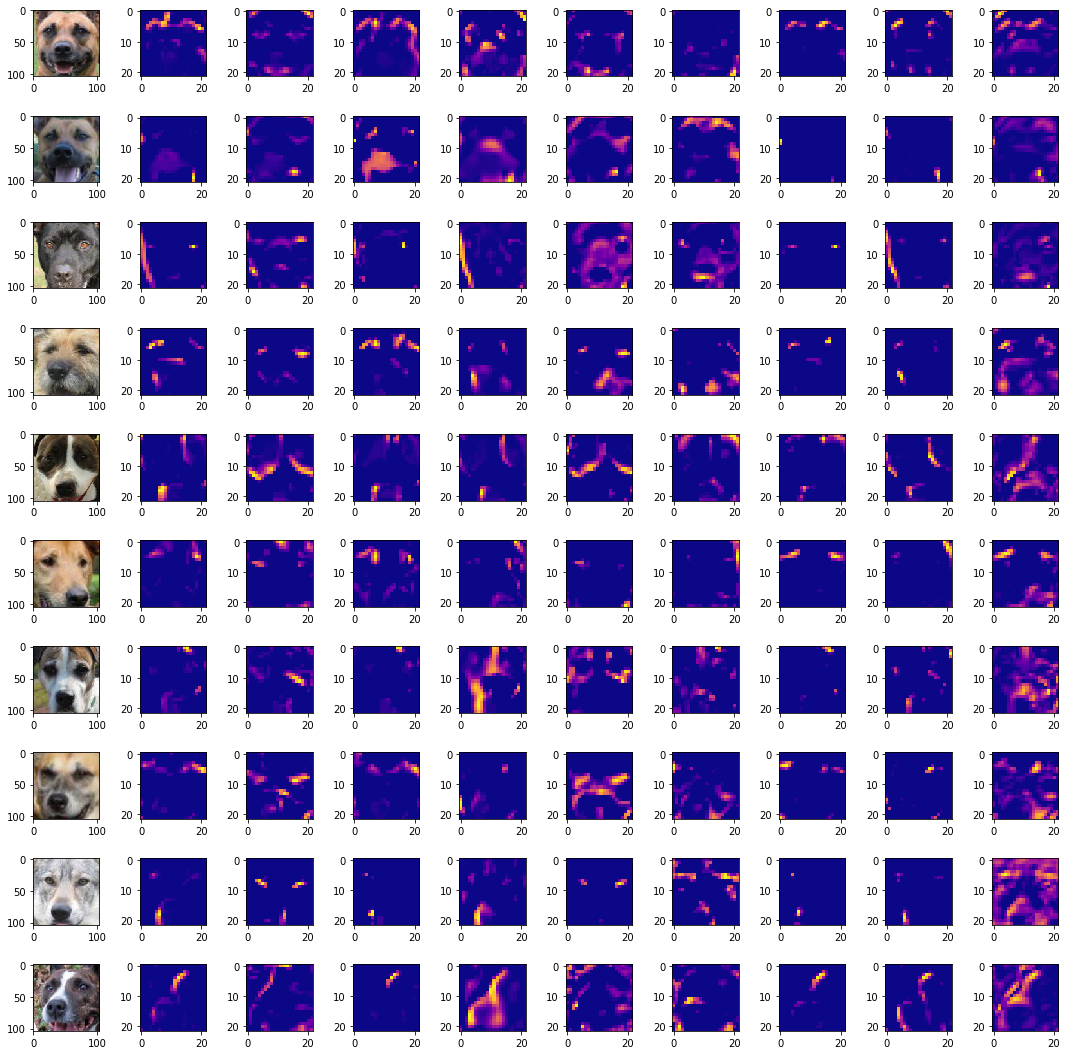

In [24]:
mod3 = tf.keras.Model(model.layers[0].input, model.layers[7].output)
predict3 = mod3.predict(images_train[0:100:10])

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(10,10,i*10+1)
    sk.io.imshow(images_train[i*10])
    
    for j in range(9):
        pred3 = np.mean(predict3[i][:,:,j*25:j*25+3],axis=-1)
        plt.subplot(10,10,i*10+2+j)
        sk.io.imshow(images_train[i*10])
        plt.imshow(pred3,cmap='plasma')

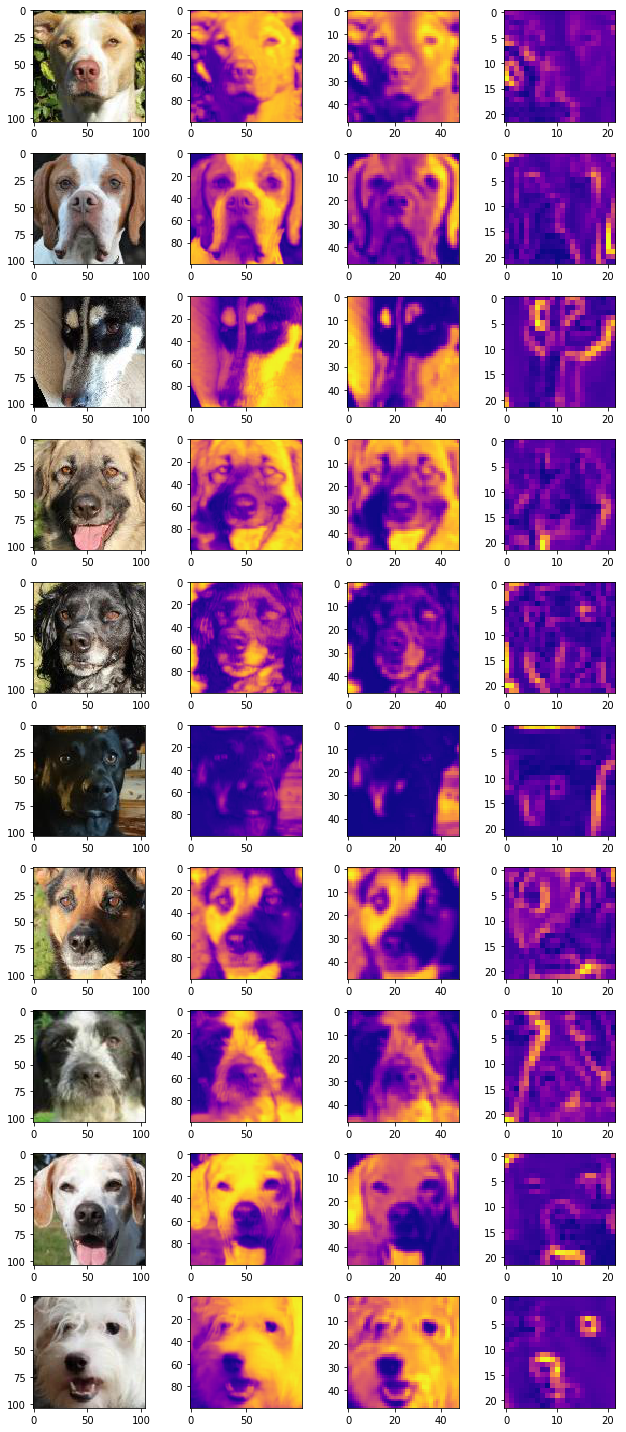

In [36]:
mod1 = tf.keras.Model(model.layers[0].input, model.layers[1].output)
predict1 = mod1.predict(images_train[0:100:10])

mod2 = tf.keras.Model(model.layers[0].input, model.layers[4].output)
predict2 = mod2.predict(images_train[0:100:10])

mod3 = tf.keras.Model(model.layers[0].input, model.layers[7].output)
predict3 = mod3.predict(images_train[0:100:10])

plt.figure(figsize=(9,20))
for i in range(10):
    pred1 = np.mean(predict1[i],axis=-1)
    pred2 = np.mean(predict2[i],axis=-1)
    pred3 = np.mean(predict3[i],axis=-1)

    
    plt.subplot(10,4,i*4+1)
    sk.io.imshow(images_train[i*10])
    plt.subplot(10,4,i*4+2)
    plt.imshow(pred1,cmap='plasma')
    plt.subplot(10,4,i*4+3)
    plt.imshow(pred2,cmap='plasma')
    plt.subplot(10,4,i*4+4)
    plt.imshow(pred3,cmap='plasma')

### Archives:

In [12]:
# dogfacenet_v7
out_num = len(unique)

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Lambda

base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(104, 104, 3))
x = base_model.output
# x = base_model.layers[8].output
# x = MaxPooling2D((2,2))(x)
# x = Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(18)(x)
x = Lambda(lambda x: tf.math.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss=triplet,
              optimizer='rmsprop',
              metrics=[triplet_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 104, 104, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 104, 104, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 104, 104, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 52, 52, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 52, 52, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 52, 52, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 26, 26, 128)       0         
__________

In [17]:
triplet_train_pre = tf.keras.applications.vgg16.preprocess_input(triplet_train)

In [21]:
history=model.fit(
    triplet_train_pre,
    np.zeros((len(triplet_train),18)),
    batch_size = 63,
    epochs = 100,
    validation_split=0.1
)

Train on 27000 samples, validate on 3000 samples
Epoch 1/100
27000/27000 [==============================] - 75s 3ms/step - loss: 6.2989 - triplet_acc: 0.5084 - val_loss: 6.2688 - val_triplet_acc: 0.6670
Epoch 2/100
27000/27000 [==============================] - 74s 3ms/step - loss: 6.2962 - triplet_acc: 0.5050 - val_loss: 6.2688 - val_triplet_acc: 0.6750
Epoch 3/100
27000/27000 [==============================] - 74s 3ms/step - loss: 6.2955 - triplet_acc: 0.4880 - val_loss: 6.2688 - val_triplet_acc: 0.6810
Epoch 4/100
27000/27000 [==============================] - 75s 3ms/step - loss: 6.2901 - triplet_acc: 0.4918 - val_loss: 6.2689 - val_triplet_acc: 0.6990
Epoch 5/100
 3591/27000 [==>...........................] - ETA: 1:26 - loss: 6.3122 - triplet_acc: 0.4971

KeyboardInterrupt: 

In [31]:
# dogfacenet_v8 : inspired from FaceNet paper
emb_size = 64

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

model = Sequential()
model.add(Conv2D(64, (5, 5), strides=(2,2), activation='relu', input_shape=(104, 104, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(192, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(192, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(384, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(256, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(256, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x)))

model.compile(loss=triplet,
              optimizer='adagrad',
              metrics=[triplet_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 50, 50, 64)        4864      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
dropout_19 (Dropout)         (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 25, 25, 64)        4160      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 25, 25, 192)       110784    
_________________________________________________________________
batch_normalization_7 (Batch (None, 25, 25, 192)       768       
__________

In [13]:
# dogfacenet_v4
out_num = len(unique)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(104, 104, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Cosine(out_num))

model.compile(loss=cosine,
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 102, 102, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 102, 102, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 49, 256)       147712    
_________________________________________________________________
activation_1 (Activation)    (None, 49, 49, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 512)       1180160   
__________

In [14]:
history = model.fit_generator(
    train_datagen.flow(images_train,labels_train,batch_size = 64),
    epochs = 12,
    validation_data=(images_valid,labels_valid)
)

Epoch 1/12
40/40 [==============================] - ETA: 6:40 - loss: 3033.9841 - acc: 0.0000e+ - ETA: 3:20 - loss: 3193.7477 - acc: 0.0078   - ETA: 2:14 - loss: 3131.7262 - acc: 0.00 - ETA: 1:41 - loss: 3100.9213 - acc: 0.00 - ETA: 1:21 - loss: 3011.6771 - acc: 0.01 - ETA: 1:07 - loss: 2969.4160 - acc: 0.01 - ETA: 57s - loss: 2898.0631 - acc: 0.0089 - ETA: 50s - loss: 2821.5505 - acc: 0.007 - ETA: 44s - loss: 2773.2350 - acc: 0.006 - ETA: 39s - loss: 2718.2655 - acc: 0.006 - ETA: 35s - loss: 2673.9746 - acc: 0.005 - ETA: 32s - loss: 2639.0772 - acc: 0.005 - ETA: 29s - loss: 2607.5262 - acc: 0.004 - ETA: 27s - loss: 2588.1751 - acc: 0.004 - ETA: 24s - loss: 2556.4133 - acc: 0.004 - ETA: 22s - loss: 2525.0515 - acc: 0.004 - ETA: 21s - loss: 2379.7240 - acc: 0.004 - ETA: 19s - loss: 2365.8392 - acc: 0.004 - ETA: 18s - loss: 2358.0670 - acc: 0.004 - ETA: 16s - loss: 2344.6071 - acc: 0.004 - ETA: 15s - loss: 2334.9984 - acc: 0.004 - ETA: 14s - loss: 2315.3236 - acc: 0.004 - ETA: 13s - loss

40/40 [==============================] - ETA: 12s - loss: 1553.2555 - acc: 0.046 - ETA: 11s - loss: 1557.4442 - acc: 0.023 - ETA: 11s - loss: 1559.9218 - acc: 0.020 - ETA: 11s - loss: 1564.8853 - acc: 0.019 - ETA: 11s - loss: 1560.9692 - acc: 0.021 - ETA: 10s - loss: 1562.4371 - acc: 0.020 - ETA: 10s - loss: 1563.6058 - acc: 0.017 - ETA: 10s - loss: 1563.6732 - acc: 0.019 - ETA: 9s - loss: 1562.8299 - acc: 0.019 - ETA: 9s - loss: 1560.2613 - acc: 0.02 - ETA: 9s - loss: 1559.2021 - acc: 0.02 - ETA: 9s - loss: 1559.6456 - acc: 0.02 - ETA: 8s - loss: 1559.8105 - acc: 0.02 - ETA: 8s - loss: 1562.1020 - acc: 0.02 - ETA: 8s - loss: 1564.2353 - acc: 0.02 - ETA: 7s - loss: 1473.9175 - acc: 0.01 - ETA: 6s - loss: 1479.2918 - acc: 0.01 - ETA: 6s - loss: 1484.0584 - acc: 0.01 - ETA: 6s - loss: 1487.1040 - acc: 0.01 - ETA: 5s - loss: 1490.0914 - acc: 0.02 - ETA: 5s - loss: 1493.1654 - acc: 0.02 - ETA: 5s - loss: 1496.8550 - acc: 0.02 - ETA: 5s - loss: 1499.7177 - acc: 0.02 - ETA: 4s - loss: 1503.3

In [41]:
model.save('../output/model/dogfacenet_v6_cosine.h5')

### Train it

In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-5),
              metrics=['accuracy'])

In [18]:
model.fit_generator(
    train_datagen.flow(images_train,labels_train,batch_size = 64),
    epochs = 50,
    validation_data=(images_valid,labels_valid)
)

Epoch 1/50


c:\users\guillaume\anaconda3\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\guillaume\anaconda3\lib\site-packages\keras_preprocessing\image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


13/13 [==============================] - ETA: 1:29 - loss: 4.8474 - acc: 0.0000e+0 - ETA: 41s - loss: 4.8427 - acc: 0.0156    - ETA: 25s - loss: 4.8440 - acc: 0.01 - ETA: 17s - loss: 4.8413 - acc: 0.01 - ETA: 12s - loss: 4.8375 - acc: 0.01 - ETA: 9s - loss: 4.8348 - acc: 0.0140 - ETA: 6s - loss: 4.8315 - acc: 0.016 - ETA: 5s - loss: 4.8274 - acc: 0.014 - ETA: 3s - loss: 4.8269 - acc: 0.018 - ETA: 2s - loss: 4.8270 - acc: 0.020 - ETA: 1s - loss: 4.8270 - acc: 0.021 - ETA: 0s - loss: 4.8276 - acc: 0.021 - 9s 674ms/step - loss: 4.8283 - acc: 0.0221 - val_loss: 4.8029 - val_acc: 0.0290
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 4.7678 - acc: 0.062 - ETA: 0s - loss: 4.7703 - acc: 0.039 - ETA: 0s - loss: 4.7796 - acc: 0.031 - ETA: 1s - loss: 4.7835 - acc: 0.027 - ETA: 0s - loss: 4.7769 - acc: 0.031 - ETA: 0s - loss: 4.7819 - acc: 0.026 - ETA: 0s - loss: 4.7791 - acc: 0.026 - ETA: 0s - loss: 4.7824 - acc: 0.027 - ETA: 0s - loss: 4.7803 - acc: 0.024 - ETA: 0s - loss: 4

Epoch 15/50
13/13 [==============================] - ETA: 1s - loss: 4.5012 - acc: 0.125 - ETA: 1s - loss: 4.4540 - acc: 0.125 - ETA: 1s - loss: 4.4515 - acc: 0.125 - ETA: 1s - loss: 4.4257 - acc: 0.148 - ETA: 1s - loss: 4.4377 - acc: 0.140 - ETA: 1s - loss: 4.4397 - acc: 0.140 - ETA: 0s - loss: 4.4405 - acc: 0.147 - ETA: 0s - loss: 4.4501 - acc: 0.144 - ETA: 0s - loss: 4.4489 - acc: 0.147 - ETA: 0s - loss: 4.4454 - acc: 0.150 - ETA: 0s - loss: 4.4487 - acc: 0.149 - ETA: 0s - loss: 4.4516 - acc: 0.145 - 2s 172ms/step - loss: 4.4499 - acc: 0.1480 - val_loss: 4.3780 - val_acc: 0.1594
Epoch 16/50
13/13 [==============================] - ETA: 2s - loss: 4.4242 - acc: 0.156 - ETA: 2s - loss: 4.4119 - acc: 0.156 - ETA: 1s - loss: 4.4161 - acc: 0.166 - ETA: 1s - loss: 4.4338 - acc: 0.164 - ETA: 1s - loss: 4.4340 - acc: 0.175 - ETA: 1s - loss: 4.4467 - acc: 0.161 - ETA: 1s - loss: 4.4539 - acc: 0.151 - ETA: 1s - loss: 4.4572 - acc: 0.152 - ETA: 0s - loss: 4.4554 - acc: 0.152 - ETA: 0s - loss: 

KeyboardInterrupt: 

In [49]:
model.save('../output/model/small_net_2.h5')